# Testing Pruning Network Module

In [2]:
# test the pruning
import numpy as np
import matplotlib.pyplot as plt
from pyreco.utils_data import sequence_to_sequence as seq_2_seq
from pyreco.custom_models import RC as RC
from pyreco.layers import InputLayer, ReadoutLayer
from pyreco.layers import RandomReservoirLayer
from pyreco.optimizers import RidgeSK
from pyreco.pruning import NetworkPruner
import networkx as nx
from tqdm import trange
import pickle

## 1. RC models

In [3]:
####Random RC with PyReCo
def RandPyReCoRC(Nodes_init, density_init, leakage_rate, frac_inp_init, frac_out_init, ridge_alpha, x_train, y_train, x_test, y_test):
    input_shape = x_train.shape[1:]
    output_shape = y_train.shape[1:]

    # build a classical RC
    model = RC()
    model.add(InputLayer(input_shape=input_shape))
    model.add(RandomReservoirLayer(nodes=Nodes_init, density=density_init, activation="tanh", leakage_rate=leakage_rate, fraction_input=frac_inp_init ))
    model.add(ReadoutLayer(output_shape, fraction_out=frac_out_init))

    # Compile the model
    optim = RidgeSK(alpha=ridge_alpha)
    model.compile(optimizer=optim, metrics=["mean_squared_error"])

    # Train the model
    model.fit(x_train, y_train)
    print(f"RandNet created. Score: \t\t\t{model.evaluate(x=x_test, y=y_test)[0]:.4f}")

    return model

##### prune the model
def PrunPyReCO(model, Stop_minima, Min_nodes, Patience, Candidate_fraction, Remove_isolated, 
               Metrics, Maintain_spectral_r, Return_best_model, x_train, y_train, x_test, y_test):
    pruner = NetworkPruner(stop_at_minimum=Stop_minima, min_num_nodes=Min_nodes, patience=Patience,\
                            candidate_fraction=Candidate_fraction, remove_isolated_nodes=Remove_isolated,\
                            metrics=Metrics, maintain_spectral_radius=Maintain_spectral_r, return_best_model=Return_best_model)
    model_pruned, history = pruner.prune(model=model, data_train=(x_train, y_train), data_val=(x_test, y_test))

    print(f"\n\ntook {history['iteration'][-1]+1} iterations to prune the model")
    for key in history["graph_props"].keys():
        print(f"{key}: \t initial model {history['graph_props'][key][0]:.4f}; \t final model: {history['graph_props'][key][-1]:.4f}")

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(history["num_nodes"], history["loss"], label="loss")
    plt.xlabel("number of nodes")
    plt.ylabel("loss")
    plt.subplot(1, 2, 2)
    for key in history["graph_props"].keys():
        plt.plot(history["num_nodes"], history["graph_props"][key], label=key)
    plt.xlabel("number of nodes")
    plt.yscale("log")
    plt.legend()
    plt.show()

    return model_pruned, history

def Predict_and_Plot(model, model_pruned, x_test, y_test):
    # Predicrt the test data
    y_pred = model.predict(x_test)
    y_pred_pruned = model_pruned.predict(x_test)

    Ts=800
    plt.figure(figsize=(8, 3), dpi=100)
    plt.plot(y_test[0, :Ts, 0], label="ground truth", lw=1, color="#1D3557")
    plt.plot(y_pred[0, :Ts, 0], label="prediction (Inital Net)",lw=1.75, color="blue", alpha=0.5)
    plt.plot(y_pred_pruned[0, :Ts, 0], label="prediction (Pruned)",lw=1.25, color="#E63946")
    plt.legend()
    plt.xlabel("time")
    plt.tight_layout()
    plt.savefig("predictions_model.png")
    plt.show()


def Rand_Prun_Reps(Reps, *args):
    Model_rands = []; Model_pruneds = []; Histories = []
    for i in trange(Reps):
        model_rand_i = RandPyReCoRC(Nodes_init, density_init, leakage_rate, frac_inp_init, frac_out_init, ridge_alpha, x_train, y_train, x_test, y_test)
        model_pruned_i, history_i = PrunPyReCO(model_rand_i, Stop_minima, Min_nodes, Patience, Candidate_fraction, Remove_isolated, \
                    Metrics, Maintain_spectral_r, Return_best_model, x_train, y_train, x_test, y_test)
        
        Predict_and_Plot(model_rand_i, model_pruned_i, x_test, y_test)

        Model_rands.append(model_rand_i); Model_pruneds.append(model_pruned_i); Histories.append(history_i)

    best_pruned_indices = Best_Pruned_Indices(Histories, Model_pruneds)

    ####Save the data
    Rand_Params, Prun_Params = ParaReturn(Nodes_init, density_init, leakage_rate, frac_inp_init, frac_out_init,
                                      ridge_alpha, Stop_minima, Min_nodes, Patience, Candidate_fraction, Remove_isolated, 
                                      Metrics, Maintain_spectral_r, Return_best_model)
    if SaveYN == True:
        SaveData(SaveDir, SaveName, Rand_Params, Model_rands, Prun_Params, Model_pruneds, Histories, best_pruned_indices)
        
    return Model_rands, Model_pruneds, Histories, best_pruned_indices

# Supporting functions

In [4]:
def Best_Pruned_Indices(Histories, Model_pruneds):
    best_pruned_indices = []
    for i in range(len(Histories)):
        best_pruned_index = int(np.where(np.array(Histories[i]['num_nodes']) == Model_pruneds[i].reservoir_layer.nodes)[0][0])
        best_pruned_indices.append(best_pruned_index)
    return best_pruned_indices

def SaveData(SaveDir, SaveName, Rand_Params, Model_rands, Prun_Params, Model_pruneds, Histories, best_pruned_indices):
    data = {'Rand_Params': Rand_Params,'Model_rands': Model_rands,'Prun_Params': Prun_Params, 'Model_pruneds': Model_pruneds,
        'Histories': Histories, 'best_pruned_indices': best_pruned_indices}
    with open(SaveDir + SaveName, 'wb') as f:
        pickle.dump(data, f)

def ParaReturn(*args):
    Rand_Params = {'Nodes_init': Nodes_init,'density_init': density_init,'leakage_rate': leakage_rate,
               'frac_inp_init': frac_inp_init,'frac_out_init': frac_out_init,'ridge_alpha': ridge_alpha}

    Prun_Params = {'Stop_minima': Stop_minima,'Min_nodes': Min_nodes,'Patience': Patience,'Candidate_fraction': Candidate_fraction,
                'Remove_isolated': Remove_isolated,'Metrics': Metrics,'Maintain_spectral_r': Maintain_spectral_r,'Return_best_model': Return_best_model}

    return Rand_Params, Prun_Params

# Define Task

(4, 2500, 1) (4, 2500, 1) (2, 2500, 1) (2, 2500, 1)


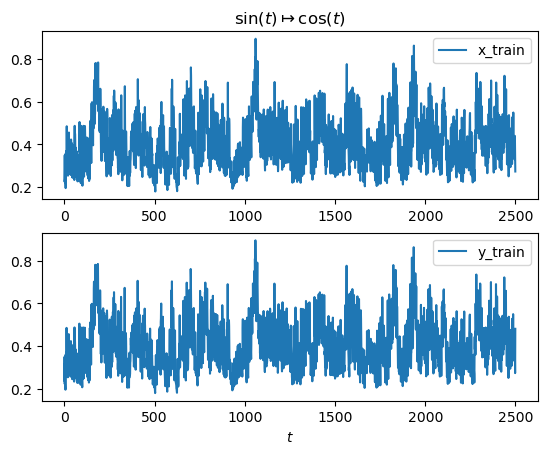

In [5]:
from benchmark_systems import load_data

# load data
x_train, y_train, x_test, y_test = load_data(name="narma10", n_samples=6)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 

sample_idx = 0
plt.figure()
plt.subplot(2, 1, 1)
for i in range(x_train.shape[2]):
    plt.plot(x_train[sample_idx, :, i], label="x_train")
plt.legend()
plt.title(r"$\sin(t) \mapsto \cos(t)$")

plt.subplot(2, 1, 2)
for i in range(y_train.shape[2]):
    plt.plot(y_train[sample_idx, :, i], label="y_train")
plt.legend()
plt.xlabel(r"$t$")
plt.show()

# Run the full model with reps

In [ ]:
##### Initial RandNet and RC params ########
Nodes_init=70; density_init=0.1
leakage_rate=0.9; ridge_alpha=1e-6
frac_inp_init=0.5; frac_out_init=0.5; 

#### Pruning Model params #################
Stop_minima=False; Min_nodes=10
Patience=5; Candidate_fraction=0.25  # 1.0 would try out every possible node
Remove_isolated=True; Metrics=["mse"]
Maintain_spectral_r=False; Return_best_model=True

#### Saving options #######################
SaveDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/7.Pruning_RC/PrunedRC/Data/'
SaveName = 'NARMA10_AJ.pkl'
SaveYN = True

######Run Pruning Reps#####################
Reps=10
Model_rands, Model_pruneds, Histories, best_pruned_indices = Rand_Prun_Reps(Reps, Nodes_init, density_init, leakage_rate, frac_inp_init, frac_out_init, ridge_alpha,\
                                                    Stop_minima, Min_nodes, Patience, Candidate_fraction, Remove_isolated, Metrics, Maintain_spectral_r,\
                                                    Return_best_model, x_train, y_train, x_test, y_test, SaveDir, SaveName, SaveYN)

print(len(Model_rands))    

  0%|          | 0/5 [00:00<?, ?it/s]

RandNet created. Score: 			0.0067
pruning iteration 0
current reservoir size: 70, current loss: 0.00673662
propose 4/70 nodes for pruning
deletion of candidate node 37. loss: 	0.007194 (-6.788%)
deletion of candidate node 68. loss: 	0.006748 (-0.163%)
deletion of candidate node 38. loss: 	0.007382 (-9.577%)
deletion of candidate node 40. loss: 	0.006761 (-0.363%)
Loss 0.006748 is larger target score 0.000000. Continuing pruning
Number of nodes 69 is larger than minimum number of nodes 10. Continuing pruning
pruning node 1, resulting in loss 0.006748
loss improvement by -0.163%

pruning iteration 1
current reservoir size: 69, current loss: 0.00674758
propose 4/69 nodes for pruning
deletion of candidate node 55. loss: 	0.006791 (-0.639%)
deletion of candidate node 38. loss: 	0.007443 (-10.309%)
deletion of candidate node 13. loss: 	0.007477 (-10.804%)
deletion of candidate node 48. loss: 	0.006765 (-0.257%)
Loss 0.006765 is larger target score 0.000000. Continuing pruning
Number of nodes

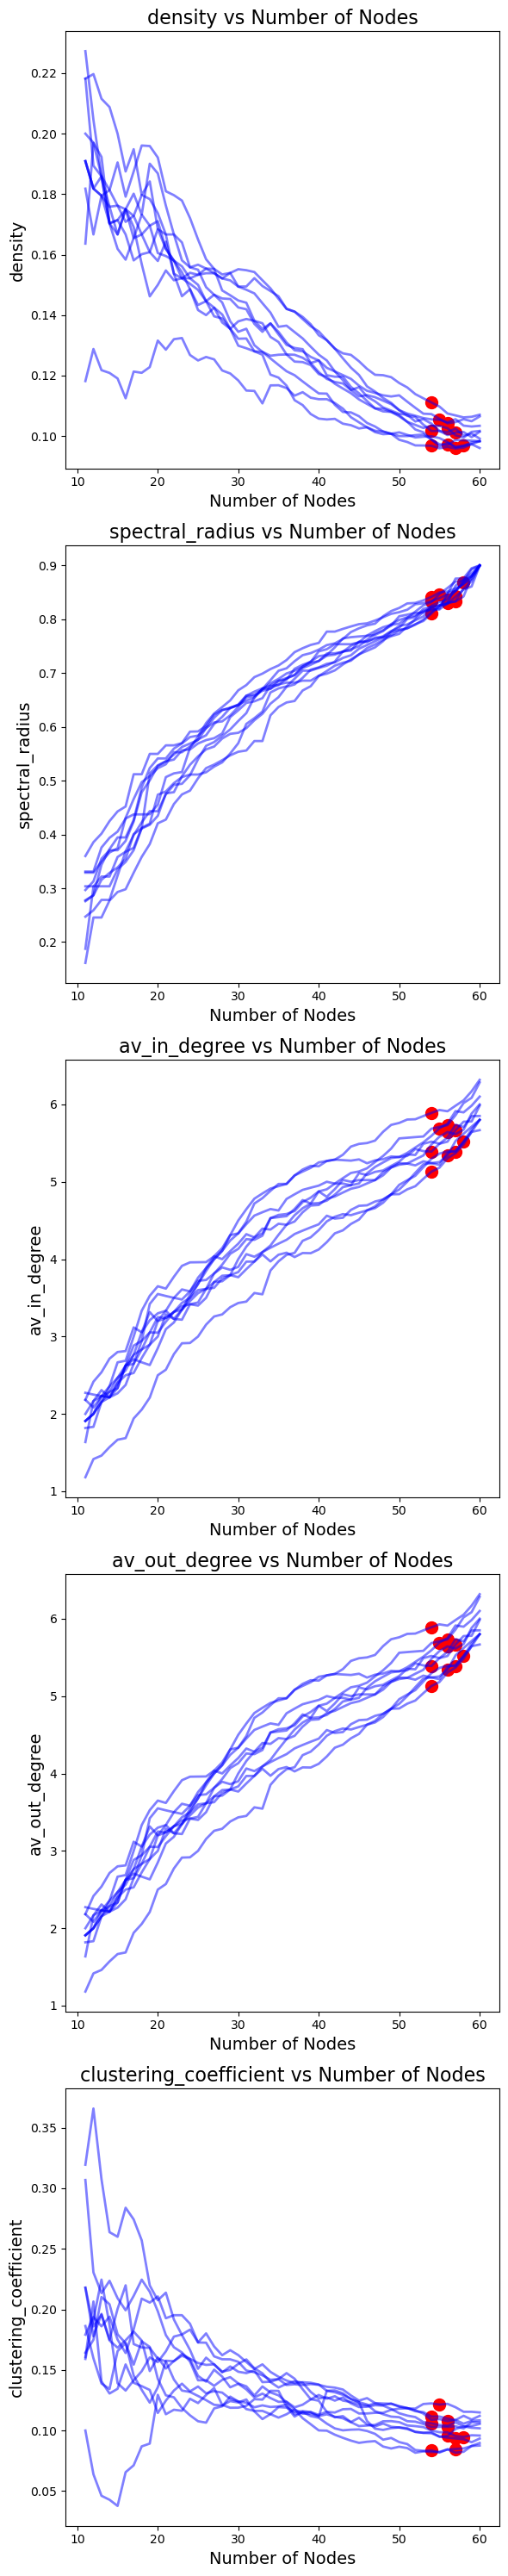

In [18]:
num_properties = len(Histories[0]['graph_props'])
fig, axes = plt.subplots(num_properties, 1, figsize=(6, 6 * num_properties), dpi=100)

for idx, prop in enumerate(Histories[0]['graph_props'].keys()):
    ax = axes[idx] if num_properties > 1 else axes
    for i in range(Reps):
        ax.plot(Histories[i]['num_nodes'], Histories[i]['graph_props'][prop], lw=2, color="blue", alpha=0.5)
        ax.scatter(Histories[i]['num_nodes'][best_pruned_indices[i]], Histories[i]['graph_props'][prop][best_pruned_indices[i]], color="red", s=100)
    ax.set_xlabel("Number of Nodes", fontsize=14)
    ax.set_ylabel(prop, fontsize=14)
    ax.set_title(f"{prop} vs Number of Nodes", fontsize=16)

plt.tight_layout()
plt.show()


In [92]:
Histories[0].keys()

dict_keys(['loss', 'metrics', 'num_nodes', 'iteration', 'graph_props', 'candidate_scores', 'candidate_nodes', 'candidate_node_props', 'candidate_graph_props_before', 'candidate_graph_props_after', 'idx_prune', 'del_node_props'])

In [99]:
Histories[0]['candidate_node_props'][0]

{'degree': [15, 12, 10, 16, 17, 15],
 'in_degree': [9, 9, 4, 9, 9, 11],
 'out_degree': [6, 3, 6, 7, 8, 4],
 'clustering_coefficient': [0.11904761904761904,
  0.08461538461538462,
  0.044444444444444446,
  0.0847457627118644,
  0.12962962962962962,
  0.12135922330097088],
 'betweenness_centrality': [0.04052308015582174,
  0.019053833306539956,
  0.019876184700816875,
  0.037313617692159726,
  0.04494206746449268,
  0.02961959941852348],
 'pagerank': [0.021608342550183762,
  0.018675320545727313,
  0.01720796504369363,
  0.025476160366586807,
  0.032260832240828215,
  0.031392602806558825]}

In [71]:
Best_pruned_index = int(np.where(np.array(Histories[0]['num_nodes']) == Model_pruneds[0].reservoir_layer.nodes)[0][0])
Best_pruned_index

9

In [69]:
Best_pruned_index = np.where(np.array(Histories[0]['num_nodes']) == Model_pruneds[0].reservoir_layer.nodes)[0][0]
Best_pruned_index

np.int64(9)

In [55]:
Histories[0]['num_nodes']

[60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45]

In [56]:
Model_pruneds[0].reservoir_layer.nodes

51

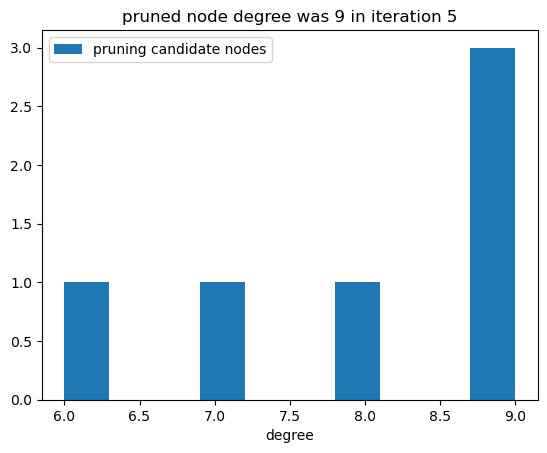

In [127]:
# investigate a single decision: which node was pruned, and which pruning candidate properties do we have?
iteration = 5
plt.figure()
plt.hist(x=history["candidate_node_props"][iteration]["degree"])
plt.title(
    f'pruned node degree was {history["del_node_props"]["degree"][iteration]} in iteration {iteration}'
)
plt.legend(["pruning candidate nodes"])
plt.xlabel("degree")
plt.show()
